In [1]:
import glob
import os
import json

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import cPickle as pkl


from pipeline.python.classifications import experiment_classes as util


import scipy.stats as spstats

from pipeline.python.utils import label_figure, natural_keys
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import get_dataset_stats as gd

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [2]:
%matplotlib notebook

# Get dataset info

In [3]:
options = ['-t', 'traces001']

optsE = gd.extract_options(options)


rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
state  = optsE.state
response_type = optsE.response_type
print response_type
print aggregate_dir

dff
/n/coxfs01/julianarhee/aggregate-visual-areas


In [4]:
sdata = gd.get_dataset_info(aggregate_dir=aggregate_dir, traceid=traceid,
                           fov_type=fov_type, state=state)

# Get responsive cells

In [6]:
responsive_test = 'nstds'
responsive_thr = 10
n_stds = 2.5

stats_desc = util.get_stats_desc(traceid=traceid, responsive_test=responsive_test, 
                    responsive_thr=responsive_thr, n_stds=n_stds)
print stats_desc

stats-traces001-corrected-dff-nstds-thr-10.00


In [8]:
visual_area = 'V1'
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'


In [9]:
exp = util.Gratings(animalid, session, fov, traceid=traceid)
roi_list, nrois_total = exp.get_responsive_cells(responsive_test=responsive_test, 
                                                responsive_thr=responsive_thr, 
                                                n_stds=n_stds)

stats = exp.get_trial_metrics() #ex.get_trial_metrics()
tstats = stats[roi_list]



... [JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 10.00')
... loading data array


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:998: RuntimeWarning: invalid value encountered in divide
  F0 = np.nanmean(dset['corrected'][:] / dset['dff'][:] )


... offset: 644.22
... adjusting for equal reps / condn...


# Group by stimulus condition and average

In [10]:
sdf = exp.data.sdf
stimd = sdf[sdf['size']==200]
curr_configs = stimd.index.tolist()

labels = exp.data.labels
trial_refix = dict((trial, i) for i, trial in enumerate(sorted(labels['trial'].unique(), key=natural_keys)))
cfgs = []
for config, g in labels.groupby(['config']):
    if config not in curr_configs:
        continue
    trial_ixs = np.array([trial_refix[trial] for trial in sorted(g['trial'].unique(), key=natural_keys)])
    curr_trials = tstats.loc[trial_ixs]
    assert len(np.where(np.isnan(curr_trials))[0]) == 0
    cfgs.append( pd.Series(data=curr_trials.mean(axis=0), name=config) )
configdf = pd.DataFrame(cfgs)


In [29]:
corr_method = 'pearson'

In [45]:
corr = configdf.corr(method=corr_method)
print corr.shape

(127, 127)


<IPython.core.display.Javascript object>


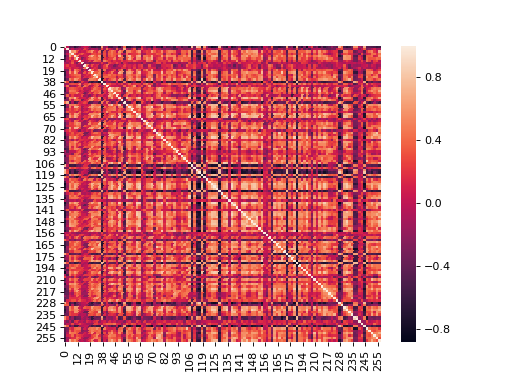

In [46]:
pl.figure()
g = sns.heatmap(corr)

<IPython.core.display.Javascript object>


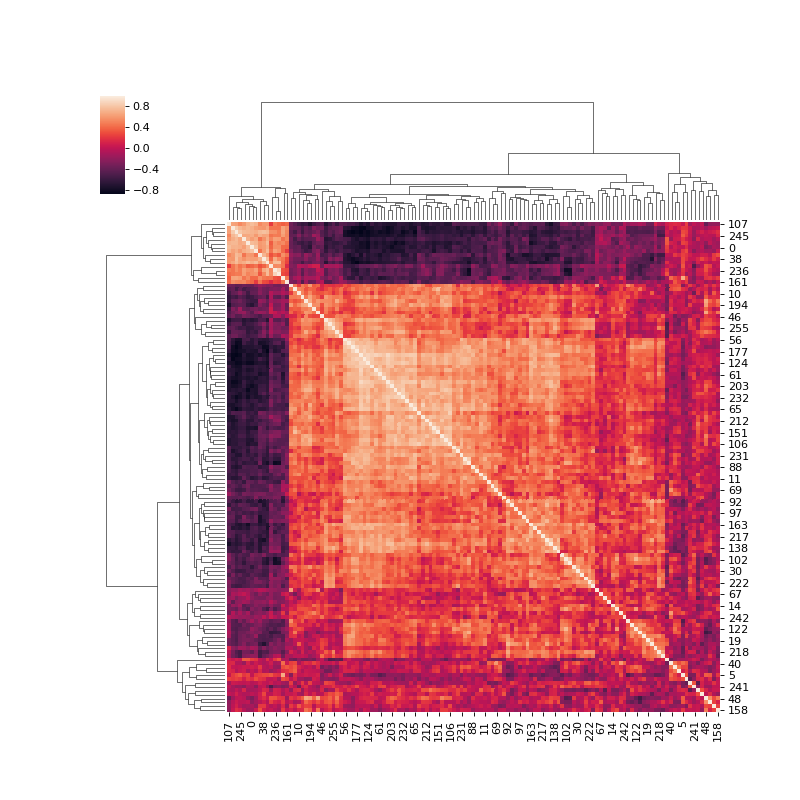

In [40]:
g = sns.clustermap(corr)

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [48]:
z = linkage(configdf)

<IPython.core.display.Javascript object>


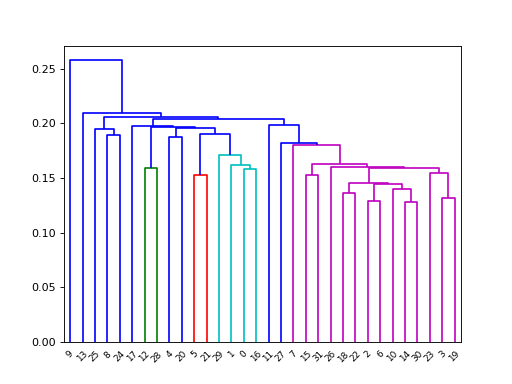

In [55]:
X = configdf.values #[[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
Z = linkage(X, 'single')
pl.figure()
dn = dendrogram(Z)

In [57]:
dn['leaves']

[9,
 13,
 25,
 8,
 24,
 17,
 12,
 28,
 4,
 20,
 5,
 21,
 29,
 1,
 0,
 16,
 11,
 27,
 7,
 15,
 31,
 26,
 18,
 22,
 2,
 6,
 10,
 14,
 30,
 23,
 3,
 19]

In [71]:
import scipy.cluster as spcluster

In [74]:
configdf

,0,5,9,10,11,12,14,16,17,18,...,237,241,242,245,246,247,249,252,255,258
config001,-0.006802,0.004353,0.004310,0.005928,0.019720,0.023500,0.019482,0.006917,0.029689,0.006109,...,-0.021787,0.008515,0.031226,-0.019907,0.015804,0.006673,0.012902,0.060324,0.081025,0.033597
config002,-0.001118,-0.000902,0.001685,-0.002733,0.006094,0.010840,0.053535,0.000216,0.027221,0.012443,...,-0.021793,0.008228,0.011162,-0.010529,0.035891,0.015783,0.003680,-0.001745,0.059088,0.005108
config003,-0.002330,0.016323,-0.007221,0.001428,0.007730,-0.005839,0.016144,0.007857,0.050126,0.006281,...,-0.011884,-0.015352,0.022699,-0.007876,-0.006606,-0.020493,-0.002607,0.008696,-0.003878,0.000654
config004,-0.000100,0.014902,-0.005033,-0.004192,0.012410,0.000873,0.030139,-0.001413,0.065711,0.003300,...,-0.033114,0.009566,0.018418,-0.004531,0.025777,-0.000692,-0.003248,0.000889,0.000792,0.010878
config009,-0.003296,0.007524,0.014470,0.004976,0.036252,0.020137,0.027677,-0.003078,0.024530,-0.001554,...,-0.008374,-0.000658,0.010202,-0.017929,0.020895,0.002707,0.015980,-0.013284,0.016002,0.032657
config010,-0.002708,-0.010266,0.008094,0.009112,0.029970,0.002192,0.051996,0.013936,0.037390,0.001940,...,-0.025139,-0.003866,0.028534,-0.021014,0.015846,0.000068,-0.001788,0.000187,0.007790,0.008265
config011,-0.000250,0.009575,0.011219,0.003848,0.018645,0.004065,0.018331,0.008303,0.031088,0.009832,...,-0.012296,-0.004256,0.025773,-0.012857,-0.003041,0.005175,-0.000275,-0.008799,-0.005071,0.006534
config012,-0.004069,0.017650,-0.003343,0.015677,0.010375,-0.003686,0.047478,0.004553,0.064340,0.008704,...,-0.028786,-0.019324,0.032872,-0.004081,0.028458,-0.019983,0.006635,0.012245,0.010349,0.001429
config017,-0.009149,0.007488,0.030406,0.028280,0.047800,0.007054,0.025862,0.011410,0.060656,0.015664,...,-0.021405,-0.000140,0.026239,-0.021930,0.009058,0.019030,0.017022,0.025349,0.047740,0.053552
config018,-0.010299,0.007344,0.019513,0.005809,0.043448,0.017139,0.016231,-0.004488,0.061218,0.022142,...,-0.033476,0.006462,0.010459,-0.039755,0.029492,0.024705,0.034462,0.023200,0.073596,0.045540


In [77]:
g.dendrogram_col.linkage

array([[  0.00000000e+00,   5.10000000e+01,   3.72284852e-02,
          2.00000000e+00],
       [  1.50000000e+01,   6.20000000e+01,   3.74746605e-02,
          2.00000000e+00],
       [  1.20000000e+01,   1.30000000e+01,   3.87683614e-02,
          2.00000000e+00],
       [  5.30000000e+01,   8.90000000e+01,   3.87868040e-02,
          2.00000000e+00],
       [  2.00000000e+01,   1.02000000e+02,   4.03651686e-02,
          2.00000000e+00],
       [  2.00000000e+00,   3.00000000e+00,   4.06019750e-02,
          2.00000000e+00],
       [  5.40000000e+01,   1.20000000e+02,   4.09286555e-02,
          2.00000000e+00],
       [  1.00000000e+02,   1.23000000e+02,   4.12368758e-02,
          2.00000000e+00],
       [  1.28000000e+02,   1.30000000e+02,   4.14612041e-02,
          4.00000000e+00],
       [  8.30000000e+01,   1.27000000e+02,   4.38698703e-02,
          3.00000000e+00],
       [  1.31000000e+02,   1.32000000e+02,   4.49907647e-02,
          4.00000000e+00],
       [  1.10000000e

In [94]:
corr = configdf.T.corr(method=corr_method)
print corr.shape

(32, 32)


<IPython.core.display.Javascript object>


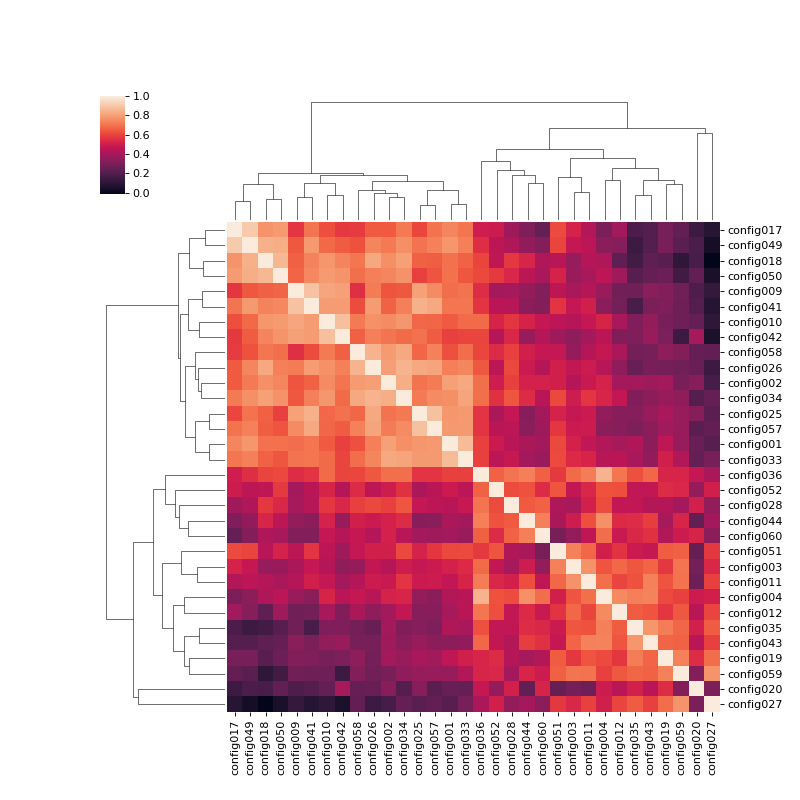

In [95]:
h = sns.clustermap(corr, method='average')

dgram = h.dendrogram_col.dendrogram
D = np.array(dgram['dcoord'])
I = np.array(dgram['icoord'])

# then the root node will be the last entry, and the length of the L/R branches will be
yy = D[-1] 
lenL = yy[1]-yy[0]
lenR = yy[2]-yy[3]


In [86]:
lenL

7.0629805329500002

In [87]:
lenR

4.6216742975534384

# Get position info

In [98]:

pos_fpath = glob.glob(os.path.join(aggregate_dir, 'roi_positions.pkl'))[0]
with open(pos_fpath, 'rb') as f:
    fovinfo = pkl.load(f)
posdf = fovinfo['positions']
fovinfo.keys()

['positions', 'ap_lim', 'ml_lim', 'dims']

# Aggregate all datasets

In [114]:
dsets = sdata[sdata['experiment']=='gratings']
df_list = []

for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    # Load data
    exp = util.Gratings(animalid, session, fov, traceid=traceid)
    roi_list, nrois_total = exp.get_responsive_cells(responsive_test=responsive_test, 
                                                    responsive_thr=responsive_thr, 
                                                    n_stds=n_stds)

    stats = exp.get_trial_metrics() #ex.get_trial_metrics()
    stats = stats[roi_list]

    # Get position info for current rois
    currpos = posdf.groupby(['animalid', 'session', 'fov']).get_group((animalid, session, fov))
    currpos = currpos[currpos['index'].isin(roi_list)]
    currpos.index = currpos['index']
    _ =currpos.pop('index')
    currpos = currpos[['ap_pos', 'ml_pos']]
        
    # Specify subset of stimulus conditions
    sdf = exp.data.sdf
    stimd = sdf[sdf['size']==200]
    curr_configs = stimd.index.tolist()

    # Average across reps:
    labels = exp.data.labels
    trial_refix = dict((trial, i) for i, trial in enumerate(sorted(labels['trial'].unique(), key=natural_keys)))
    cfgs = []
    for config, g in labels.groupby(['config']):
        if config not in curr_configs:
            continue
        trial_ixs = np.array([trial_refix[trial] for trial in sorted(g['trial'].unique(), key=natural_keys)])
        curr_trials = stats.loc[trial_ixs]
        assert len(np.where(np.isnan(curr_trials))[0]) == 0
        cfgs.append( pd.Series(data=curr_trials.mean(axis=0), name=config) )
    configdf = pd.DataFrame(cfgs)
    
    # Get correlations bewteen cells (by condition)
    corr = configdf.corr(method=corr_method)

    # For each cell, calculate correlation bw its distance from neighbors and activity of neighbors
    coeffs=[]; pvals=[];
    for roi in roi_list:
        # Get distance of each cell to current cell
        currp = currpos.loc[roi]
        curr_dists = (currpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5).values
        ixs = np.array([i for i, r in enumerate(currpos.index.tolist()) if r != roi])
        curr_dists = curr_dists[ixs]

        # Get correlation between current cell's trial values and all other cells' trial values
        curr_corrs = np.abs(corr[roi].values)
        ixs = np.array([i for i, r in enumerate(corr[roi].index.tolist()) if r!= roi])
        curr_corrs = curr_corrs[ixs]

        #fitv, regr = fit_linear_regr(curr_dists, curr_corrs, return_regr=True)
        r, p = spstats.pearsonr(curr_dists, curr_corrs)

        coeffs.append(r)
        pvals.append(r)


    df_list.append( pd.DataFrame({'corrcoef': coeffs,
                                 'pval': pvals,
                                 'visual_area': [visual_area for _ in range(len(roi_list))],
                                 'animalid': [animalid for _ in range(len(roi_list))],
                                 'fov': [fov for _ in range(len(roi_list))],
                                 'session': [session for _ in range(len(roi_list))]}, 
                                 index=roi_list))                                     

... [JC090|20190605|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 10.00')
... loading data array
... offset: 402.38
... [JC091|20190602|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 10.00')
... loading data array
... offset: 338.77
... [JC091|20190606|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 10.00')
... loading data array
... offset: 534.32
... [JC091|20190607|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 10.00')
..

In [116]:

df = pd.concat(df_list, axis=0).reset_index()
df['cell'] = df.pop('index')
print df.shape


(1877, 7)


# PLOT

In [117]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [125]:
data_identifier = '|'.join([fov_type, traceid, stats_desc, 'gratings-FF'])

<IPython.core.display.Javascript object>


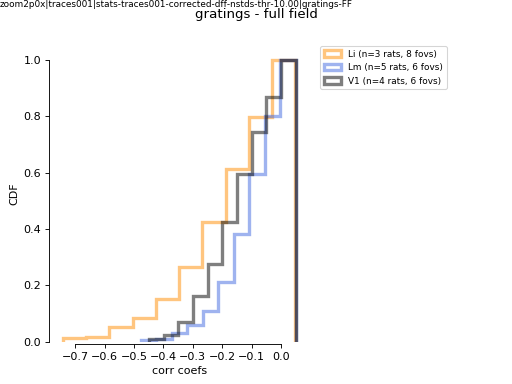

Li
Lm
V1


In [129]:
cdf = True
fig, ax = pl.subplots() #1, 3, figsize=(12,4), sharex=True, sharey=True)

for visual_area, tmpd in df.groupby(['visual_area']):
    print visual_area
    g = tmpd[tmpd['pval'] < 0.05]

    values = g['corrcoef'].values
    weights = np.ones_like(values)/float(len(values))
    nrats = len(g['animalid'].unique())
    nfovs = len(g.groupby(['animalid', 'session', 'fov']).groups)
    label = '%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)

    ax.hist(values, 
            cumulative=cdf,
            label=label,
            color=area_colors[visual_area],
            histtype='step', alpha=0.5, lw=3,
            normed=0, weights=weights)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('corr coefs')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')
    
pl.subplots_adjust(right=0.6, left=0.1, wspace=0.2)
fig.suptitle('gratings - full field')

label_figure(fig, data_identifier)

pl.savefig(os.path.join(aggregate_dir, 'corr_cell-dist_vs_trial-resp_active-cells_gratingsFF.png'))